# Crypto Portfolio Backtesting System with Nautilus Trader

This notebook establishes a foundational system for backtesting and comparing different portfolio management strategies for cryptocurrencies using the `nautilus-trader` framework.

We will implement and compare two fundamental strategies:
1.  **Hodler Strategy**: Buys and holds BTC and ETH in equal dollar amounts at the start of the backtest.
2.  **Index Rebalance Strategy**: Buys BTC and ETH and periodically rebalances the portfolio to maintain a fixed 50/50 weight.

We will use 1-hour bar data for `BTC/USDT` and `ETH/USDT`.

In [1]:
# !pip install nautilus_trader pyarrow pandas matplotlib numpy

## 1. Imports and Setup

First, we import all the necessary components from `nautilus-trader` and other libraries for data handling and plotting. We'll also set up our logging and data directory.

In [2]:
import os
import shutil
import zipfile
from decimal import Decimal
from datetime import datetime, timedelta
import glob

import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

# Core Nautilus Trader components
from nautilus_trader.backtest.node import BacktestNode
from nautilus_trader.config import BacktestRunConfig, BacktestVenueConfig, BacktestDataConfig, StrategyConfig
from nautilus_trader.core.datetime import dt_to_unix_nanos
from nautilus_trader.model.data import Bar, BarType, BarSpecification
from nautilus_trader.model.enums import AccountType, OrderSide, OrderType, PositionSide, TimeInForce
from nautilus_trader.model.events import OrderFilled
from nautilus_trader.model.identifiers import InstrumentId, StrategyId, Venue, Symbol
from nautilus_trader.model.objects import Money, Price, Quantity, Currency
from nautilus_trader.model.orders import MarketOrder, Order
from nautilus_trader.model.position import Position
from nautilus_trader.persistence.catalog import ParquetDataCatalog
from nautilus_trader.trading.strategy import Strategy
from nautilus_trader.adapters.binance import BinanceBar
from nautilus_trader.persistence.catalog import ParquetDataCatalog
from nautilus_trader.model.instruments import CurrencyPair, Instrument
# Set up logging to see the output from the backtest engine
from nautilus_trader.common.component import Logger

# Create a directory for our backtest data
CATALOG_PATH = os.path.expanduser("~/backtest_jup/data/catalog")
DATA_DIR = os.path.expanduser("~/backtest_jup/data")
if os.path.exists(CATALOG_PATH):
    shutil.rmtree(CATALOG_PATH)
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(CATALOG_PATH, exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Data catalog path: {CATALOG_PATH}")

Data directory: /Users/yb/backtest_jup/data
Data catalog path: /Users/yb/backtest_jup/data/catalog


## 5. Configure and Run the Backtest

Now we put everything together. We'll create instances of our strategies and configure the `BacktestNode` to run them simultaneously. This allows for a direct, side-by-side comparison.

In [3]:
from nautilus_trader.backtest.node import BacktestNode
from nautilus_trader.backtest.config import BacktestEngineConfig, BacktestRunConfig
from nautilus_trader.backtest.engine import BacktestEngine
from nautilus_trader.model import TraderId
from nautilus_trader.model.currencies import USDT
from nautilus_trader.model.enums import OmsType
from nautilus_trader.adapters.binance import BINANCE_VENUE
from nautilus_trader.model.enums import BookType
from nautilus_trader.model.instruments import CurrencyPair
from nautilus_trader.model.data import BarType
import matplotlib.pyplot as plt
import pandas as pd
from holder import Hodler, HodlerConfig
from timebased_rebalance import TimebasedIndexRebalance, TimebasedIndexRebalanceConfig
from ratiobased_rebalance import RatioBasedIndexRebalance, RatioBasedIndexRebalanceConfig
from utils import make_binance_bars_from_csv, make_crypto_instrument

def create_backtest_engine(trader_id: str, starting_balance: float = 100_000.0):
    """Create a standardized backtest engine with common settings."""
    config = BacktestEngineConfig(trader_id=TraderId(trader_id))
    engine = BacktestEngine(config=config)
    
    # Add venue with standard settings
    engine.add_venue(
        venue=BINANCE_VENUE,
        oms_type=OmsType.NETTING,
        account_type=AccountType.CASH,
        base_currency=None,
        starting_balances=[Money(starting_balance, USDT)],
        bar_adaptive_high_low_ordering=True
    )
    return engine

def load_market_data():
    """Load and prepare market data for backtesting."""
    instrument_settings = {
        "ETHUSDT": {
            "instrument_id": "ETHUSDT.BINANCE",
            "price_precision": 2,
            "size_precision": 6,
        },
        "BTCUSDT": {
            "instrument_id": "BTCUSDT.BINANCE",
            "price_precision": 2,
            "size_precision": 6,
        },
    }
    
    # Create instruments
    eth_instrument = make_crypto_instrument(
        "ETH-USDT", 
        price_precision=instrument_settings["ETHUSDT"]["price_precision"],
        size_precision=instrument_settings["ETHUSDT"]["size_precision"]
    )
    # Create instruments
    btc_instrument = make_crypto_instrument(
        "BTC-USDT", 
        price_precision=instrument_settings["BTCUSDT"]["price_precision"],
        size_precision=instrument_settings["BTCUSDT"]["size_precision"]
    )

    instruments = {'ETH': eth_instrument, 'BTC': btc_instrument}

    # Load bar data
    all_bars = []
    for symbol, settings in instrument_settings.items():
        pattern = os.path.expanduser(f"~/backtest_jup/data/{symbol}-1m-*.csv")
        for file_path in glob.glob(pattern):
            bars = make_binance_bars_from_csv(
                file_path=file_path,
                instrument_id=settings["instrument_id"],
                price_precision=settings["price_precision"],
                size_precision=settings["size_precision"],
            )
            all_bars.extend(bars)
    return instruments, all_bars
# Enhanced Adaptive Market Data Loading Functions

def load_market_data_adaptive(
    tokens: list[str] = ["BTC", "ETH"],
    timeframe: str = "1m",
    venue: str = "BINANCE",
    data_dir: str = "~/backtest_jup/data",
    date_pattern: str = "*",
    precision_config: dict = None,
    auto_detect_precision: bool = True
):
    """
    Load and prepare market data for backtesting with flexible token support.
    
    Args:
        tokens: List of base tokens to load (e.g., ["BTC", "ETH", "LINK"])
        timeframe: Data timeframe (e.g., "1m", "1h") 
        venue: Trading venue (default: "BINANCE")
        data_dir: Directory containing CSV files
        date_pattern: Date pattern to match files (default: "*" for all)
        precision_config: Manual precision settings for tokens
        auto_detect_precision: Whether to auto-detect precision from data
    
    Returns:
        tuple: (instruments dict, all_bars list)
    """
    
    # Default precision settings (can be overridden)
    default_precision = {
        "BTC": {"price_precision": 2, "size_precision": 6},
        "ETH": {"price_precision": 2, "size_precision": 6},
        "LINK": {"price_precision": 4, "size_precision": 2},
        "AAVE": {"price_precision": 2, "size_precision": 4},
        "UNI": {"price_precision": 4, "size_precision": 2},
        "PEPE": {"price_precision": 10, "size_precision": 0},
        "SHIB": {"price_precision": 10, "size_precision": 0},
        "ARB": {"price_precision": 4, "size_precision": 2},
    }
    
    # Use provided precision config or defaults
    if precision_config is None:
        precision_config = default_precision
    
    # Ensure all tokens have precision settings
    for token in tokens:
        if token not in precision_config:
            # Use conservative defaults for unknown tokens
            precision_config[token] = {"price_precision": 4, "size_precision": 4}
            print(f"⚠️  Using default precision for {token}: {precision_config[token]}")
    
    instruments = {}
    all_bars = []
    loaded_tokens = []
    
    # Load data for each token
    for token in tokens:
        symbol = f"{token}USDT"
        
        # Find matching files
        pattern = os.path.expanduser(f"{data_dir}/{symbol}-{timeframe}-{date_pattern}.csv")
        matching_files = glob.glob(pattern)
        
        if not matching_files:
            print(f"❌ No data files found for {symbol} with pattern: {pattern}")
            continue
        
        print(f"📊 Loading {len(matching_files)} files for {symbol}")
        
        # Auto-detect precision if enabled
        if auto_detect_precision:
            detected_precision = _detect_precision_from_files(matching_files)
            if detected_precision:
                precision_config[token].update(detected_precision)
                print(f"🔍 Auto-detected precision for {token}: {detected_precision}")
        
        # Create instrument
        try:
            instrument = make_crypto_instrument(
                f"{token}-USDT",
                price_precision=precision_config[token]["price_precision"],
                size_precision=precision_config[token]["size_precision"],
                venue=venue
            )
            instruments[token] = instrument
            
            # Load bar data from all matching files
            token_bars = []
            for file_path in sorted(matching_files):
                try:
                    bars = make_binance_bars_from_csv(
                        file_path=file_path,
                        instrument_id=f"{symbol}.{venue}",
                        price_precision=precision_config[token]["price_precision"],
                        size_precision=precision_config[token]["size_precision"],
                    )
                    token_bars.extend(bars)
                    print(f"  ✅ Loaded {len(bars)} bars from {os.path.basename(file_path)}")
                except Exception as e:
                    print(f"  ❌ Error loading {file_path}: {e}")
                    continue
            
            all_bars.extend(token_bars)
            loaded_tokens.append(token)
            print(f"📈 Total bars loaded for {token}: {len(token_bars)}")
            
        except Exception as e:
            print(f"❌ Error creating instrument for {token}: {e}")
            continue
    
    # Sort bars by timestamp for proper chronological order
    all_bars.sort(key=lambda bar: bar.ts_event)
    
    print(f"\n🎯 Summary:")
    print(f"  Tokens loaded: {loaded_tokens}")
    print(f"  Total instruments: {len(instruments)}")
    print(f"  Total bars: {len(all_bars)}")
    print(f"  Timeframe: {timeframe}")
    print(f"  Venue: {venue}")
    
    return instruments, all_bars


def _detect_precision_from_files(file_paths: list[str], sample_size: int = 1000) -> dict:
    """
    Auto-detect price and size precision from CSV files.
    
    Args:
        file_paths: List of CSV file paths to analyze
        sample_size: Number of rows to sample for precision detection
        
    Returns:
        dict: Detected precision settings
    """
    try:
        # Read a sample from the first file
        import pandas as pd
        
        columns = [
            'open_time', 'open', 'high', 'low', 'close', 'volume',
            'close_time', 'quote_asset_volume', 'number_of_trades',
            'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
        ]
        
        df = pd.read_csv(file_paths[0], header=None, names=columns, nrows=sample_size)
        
        # Analyze price precision (using 'close' column)
        price_decimals = []
        for price in df['close'].dropna():
            price_str = str(float(price))
            if '.' in price_str:
                decimals = len(price_str.split('.')[1].rstrip('0'))
                price_decimals.append(decimals)
        
        # Analyze volume precision
        volume_decimals = []
        for volume in df['volume'].dropna():
            volume_str = str(float(volume))
            if '.' in volume_str:
                decimals = len(volume_str.split('.')[1].rstrip('0'))
                volume_decimals.append(decimals)
        
        # Use the maximum precision found (conservative approach)
        price_precision = max(price_decimals) if price_decimals else 4
        size_precision = max(volume_decimals) if volume_decimals else 4
        
        # Apply reasonable limits
        price_precision = min(price_precision, 10)  # Max 10 decimal places
        size_precision = min(size_precision, 8)     # Max 8 decimal places
        
        return {
            "price_precision": price_precision,
            "size_precision": size_precision
        }
        
    except Exception as e:
        print(f"⚠️  Error detecting precision: {e}")
        return None


def discover_available_tokens(data_dir: str = "~/backtest_jup/data", timeframe: str = "1m") -> list[str]:
    """
    Discover available tokens based on existing data files.
    
    Args:
        data_dir: Directory to search for data files
        timeframe: Timeframe to filter by
        
    Returns:
        list: Available token symbols
    """
    pattern = os.path.expanduser(f"{data_dir}/*USDT-{timeframe}-*.csv")
    files = glob.glob(pattern)
    
    tokens = set()
    for file_path in files:
        filename = os.path.basename(file_path)
        # Extract token from filename (e.g., BTCUSDT-1m-2025-01.csv -> BTC)
        token = filename.split('USDT-')[0]
        tokens.add(token)
    
    return sorted(list(tokens))


def create_token_config(tokens: list[str], custom_weights: dict = None) -> dict:
    """
    Create a standardized token configuration for strategies.
    
    Args:
        tokens: List of tokens to configure
        custom_weights: Custom weight allocation (if None, uses equal weights)
        
    Returns:
        dict: Token configuration with weights
    """
    if custom_weights is None:
        # Equal weights for all tokens
        weight_per_token = 1.0 / len(tokens)
        custom_weights = {token: weight_per_token for token in tokens}
    
    # Validate weights
    total_weight = sum(custom_weights.values())
    if total_weight > 1.0:
        raise ValueError(f"Total weight ({total_weight}) exceeds 1.0")
    
    return custom_weights


def load_crypto_portfolio(
    tokens: list[str] = None,
    timeframe: str = "1m",
    equal_weights: bool = True,
    custom_weights: dict = None,
    data_dir: str = "~/backtest_jup/data"
):
    """
    High-level function to load a crypto portfolio with sensible defaults.
    
    Args:
        tokens: List of tokens (if None, discovers available tokens)
        timeframe: Data timeframe
        equal_weights: Whether to use equal weights for all tokens
        custom_weights: Custom weight allocation
        data_dir: Data directory
        
    Returns:
        tuple: (instruments, all_bars, weights_config)
    """
    # Discover tokens if not provided
    if tokens is None:
        tokens = discover_available_tokens(data_dir, timeframe)
        print(f"🔍 Auto-discovered tokens: {tokens}")
    
    # Load market data
    instruments, all_bars = load_market_data_adaptive(
        tokens=tokens,
        timeframe=timeframe,
        data_dir=data_dir
    )
    
    # Create weights configuration
    if custom_weights is None and equal_weights:
        weights_config = create_token_config(list(instruments.keys()))
    else:
        weights_config = custom_weights or {}
    
    # Convert token names to instrument IDs for weights
    instrument_weights = {}
    for token, weight in weights_config.items():
        if token in instruments:
            instrument_weights[instruments[token].id] = weight
    
    return instruments, all_bars, instrument_weights


instruments, all_bars = load_market_data_adaptive(["BTC", "ETH","LINK","AAVE","UNI","PEPE","SHIB","ARB"])


📊 Loading 7 files for BTCUSDT
🔍 Auto-detected precision for BTC: {'price_precision': 2, 'size_precision': 5}
  ✅ Loaded 43200 bars from BTCUSDT-1m-2024-11.csv
  ✅ Loaded 44640 bars from BTCUSDT-1m-2024-12.csv
  ✅ Loaded 44640 bars from BTCUSDT-1m-2025-01.csv
  ✅ Loaded 40320 bars from BTCUSDT-1m-2025-02.csv
  ✅ Loaded 44640 bars from BTCUSDT-1m-2025-03.csv
  ✅ Loaded 43200 bars from BTCUSDT-1m-2025-04.csv
  ✅ Loaded 44640 bars from BTCUSDT-1m-2025-05.csv
📈 Total bars loaded for BTC: 305280
📊 Loading 7 files for ETHUSDT
🔍 Auto-detected precision for ETH: {'price_precision': 2, 'size_precision': 4}
  ✅ Loaded 43200 bars from ETHUSDT-1m-2024-11.csv
  ✅ Loaded 44640 bars from ETHUSDT-1m-2024-12.csv
  ✅ Loaded 44640 bars from ETHUSDT-1m-2025-01.csv
  ✅ Loaded 40320 bars from ETHUSDT-1m-2025-02.csv
  ✅ Loaded 44640 bars from ETHUSDT-1m-2025-03.csv
  ✅ Loaded 43200 bars from ETHUSDT-1m-2025-04.csv
  ✅ Loaded 44640 bars from ETHUSDT-1m-2025-05.csv
📈 Total bars loaded for ETH: 305280
📊 Loading 


--- Setting up 50% ETH 50% BTC Strategy ---
2025-07-13T15:43:37.659290000Z [INFO] HODLER-ENGINE.BacktestEngine: Building system kernel
2025-07-13T15:43:37.659361000Z [INFO] HODLER-ENGINE.MessageBus: config.database=None
2025-07-13T15:43:37.659363000Z [INFO] HODLER-ENGINE.MessageBus: config.encoding='msgpack'
2025-07-13T15:43:37.659364000Z [INFO] HODLER-ENGINE.MessageBus: config.timestamps_as_iso8601=False
2025-07-13T15:43:37.659365000Z [INFO] HODLER-ENGINE.MessageBus: config.buffer_interval_ms=None
2025-07-13T15:43:37.659365001Z [INFO] HODLER-ENGINE.MessageBus: config.autotrim_mins=None
2025-07-13T15:43:37.659366000Z [INFO] HODLER-ENGINE.MessageBus: config.use_trader_prefix=True
2025-07-13T15:43:37.659366001Z [INFO] HODLER-ENGINE.MessageBus: config.use_trader_id=True
2025-07-13T15:43:37.659367000Z [INFO] HODLER-ENGINE.MessageBus: config.use_instance_id=False
2025-07-13T15:43:37.659368000Z [INFO] HODLER-ENGINE.MessageBus: config.streams_prefix='stream'
2025-07-13T15:43:37.659368001Z [I

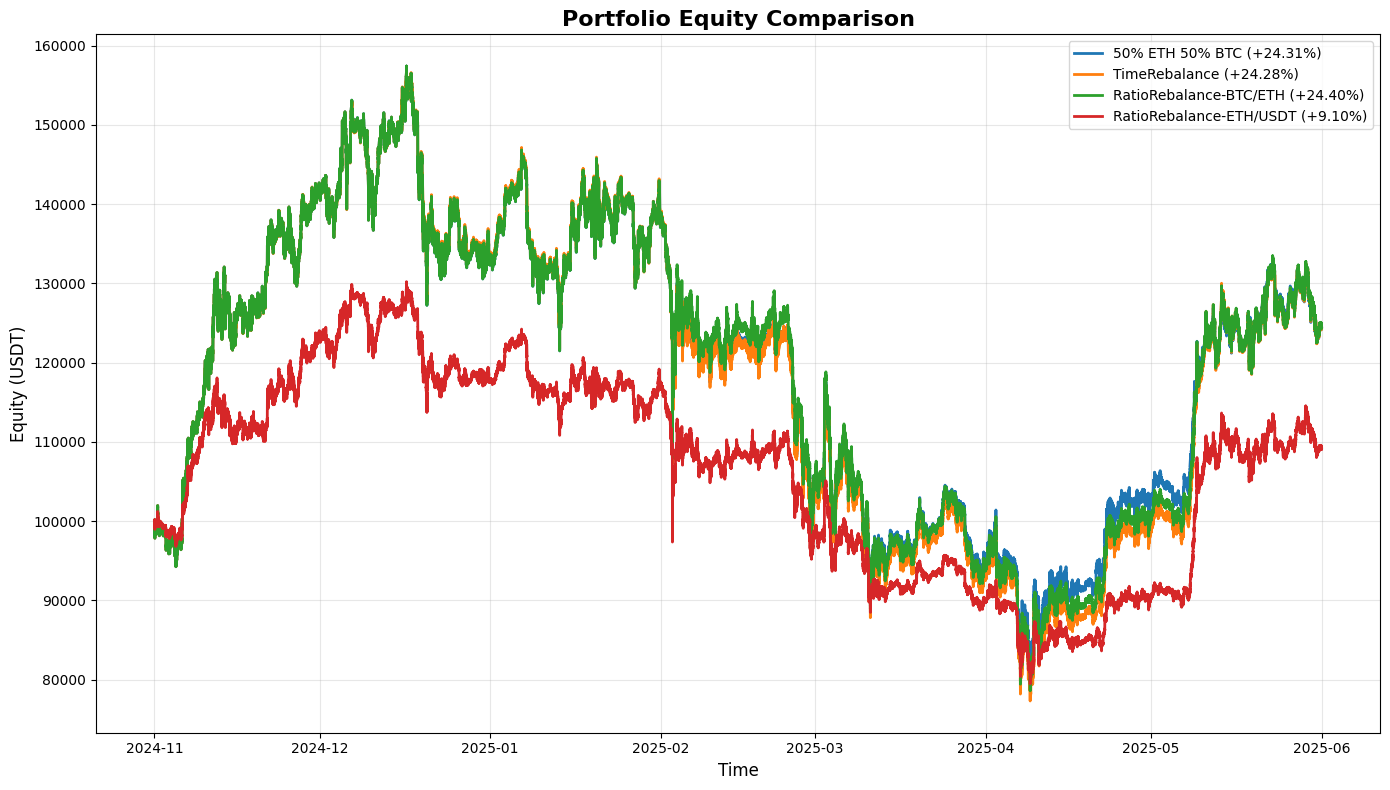


📋 ORDER HISTORY FOR 50% ETH 50% BTC STRATEGY
📊 Total Orders: 2 (BUY: 2, SELL: 0)
📅 Period: 2024-11-01 00:01:00 to 2024-11-01 00:01:00

#    TIME                 SIDE   SYMBOL                               QUANTITY        PRICE        VALUE (USDT)   
----------------------------------------------------------------------------------------------
1    2024-11-01 00:01     🟢 BUY  BTCUSDT                              0.709640        70,318.00    49,900.47      
2    2024-11-01 00:01     🟢 BUY  ETHUSDT                              19.812700       2,518.59     49,900.07      

📋 ORDER HISTORY FOR TIMEREBALANCE STRATEGY
📊 Total Orders: 32 (BUY: 16, SELL: 16)
📅 Period: 2024-11-01 00:01:00 to 2025-05-30 00:01:00

#    TIME                 SIDE   SYMBOL                               QUANTITY        PRICE        VALUE (USDT)   
----------------------------------------------------------------------------------------------
1    2024-11-01 00:01     🟢 BUY  BTCUSDT                              0.70963

In [ ]:

def run_strategy_comparison(instruments, all_bars):
    """Run multiple strategies and compare their performance."""
    
    # Strategy configurations
    strategies_config = {
        "all in BTC": {
            "engine_id": "HODLER-ENGINE",
            "strategy_class": Hodler,
            "config_class": HodlerConfig,
            "params": {},
            "weights": {instruments['BTC'].id: 0.999}  # 50% ETH, 50% USDT
        },
        "all in ETH": {
            "engine_id": "HODLER-ENGINE",
            "strategy_class": Hodler,
            "config_class": HodlerConfig,
            "params": {},
            "weights": {instruments['ETH'].id: 0.999}  # 50% ETH, 50% USDT
        },
        "50% ETH 50% BTC": {
            "engine_id": "HODLER-ENGINE",
            "strategy_class": Hodler,
            "config_class": HodlerConfig,
            "params": {},
            "weights": {instruments['ETH'].id: 0.4995, instruments['BTC'].id: 0.4995}  # 50% ETH, 50% USDT
        },
        # "ETH Bluechips": {
        #     "engine_id": "HODLER-ENGINE",
        #     "strategy_class": Hodler,
        #     "config_class": HodlerConfig,
        #     "params": {},
        #     "weights": {instruments['ETH'].id: 0.499, instruments['LINK'].id: 0.147, instruments['SHIB'].id: 0.11, instruments['UNI'].id: 0.075, instruments['PEPE'].id: 0.075, instruments['AAVE'].id: 0.065, instruments['ARB'].id: 0.028}  # 50% ETH, 50% USDT
        # },
        "TimeRebalance-BTC/ETH": {
            "engine_id": "TIME-REBALANCE-ENGINE", 
            "strategy_class": TimebasedIndexRebalance,
            "config_class": TimebasedIndexRebalanceConfig,
            "params": {"rebalance_period_days": 14},
            "weights": {instruments['ETH'].id: 0.4995, instruments['BTC'].id: 0.4995}  # 50% ETH, 50% USDT
        },
        "RatioRebalance-BTC/ETH": {
            "engine_id": "RATIO-REBALANCE-ENGINE",
            "strategy_class": RatioBasedIndexRebalance,
            "config_class": RatioBasedIndexRebalanceConfig,
            "params": {"rebalance_threshold": 0.1},  # 10% deviation threshold
            "weights": {instruments['ETH'].id: 0.4995, instruments['BTC'].id: 0.4995}  # 50% ETH, 50% USDT
        },
        # "RatioRebalance-ETH/USDT": {
        #     "engine_id": "RATIO-REBALANCE-ENGINE",
        #     "strategy_class": RatioBasedIndexRebalance,
        #     "config_class": RatioBasedIndexRebalanceConfig,
        #     "params": {"rebalance_threshold": 0.1},  # 10% deviation threshold
        #     "weights": {instruments['ETH'].id: 0.4995}  # 50% ETH, 50% USDT
        # }
    }
    
    # Storage for results
    strategy_results = {}
    engines = {}
    
    # Create and configure each strategy
    for strategy_name, config in strategies_config.items():
        print(f"\n--- Setting up {strategy_name} Strategy ---")
        
        # Create engine
        engine = create_backtest_engine(config["engine_id"])
        
        for instrument in instruments.values():
            engine.add_instrument(instrument)
            
        engine.add_data(all_bars)
        
        # Create strategy configuration
        bar_types = [BarType.from_str(f"{instrument.id}-1-HOUR-LAST-EXTERNAL") for instrument in instruments.values()]
        print(bar_types)
        strategy_config = config["config_class"](
            instruments=instruments,
            bar_types=bar_types,
            **config["params"]
        )
        
        if "weights" in config:
            strategy = config["strategy_class"](strategy_config, target_weights=config["weights"])  # 50% ETH, 50% USDT
        else:
            strategy = config["strategy_class"](strategy_config)
        
        # Create strategy instance
        # Add strategy to engine
        engine.add_strategy(strategy=strategy)
        
        # Store for execution
        engines[strategy_name] = engine
        strategy_results[strategy_name] = strategy
        
        print(f"✅ {strategy_name} strategy configured")
    
    # Run all strategies
    print(f"\n--- Running {len(strategies_config)} Strategies ---")
    for strategy_name, engine in engines.items():
        print(f"🚀 Running {strategy_name}...")
        engine.run()
        print(f"✅ {strategy_name} completed")
    
    # Collect and plot results
    print(f"\n--- Analyzing Results ---")
    plot_strategy_comparison(strategy_results)
    
    # Display order history in formatted text
    display_order_history(strategy_results)
    
    # Cleanup
    print(f"\n--- Cleanup ---")
    for strategy_name, engine in engines.items():
        engine.reset()
        engine.dispose()
        print(f"🧹 {strategy_name} engine disposed")
    
    return strategy_results

def display_order_history(strategy_results, max_orders_per_strategy=50):
    """Display order history in a formatted text table for all strategies."""
    
    for strategy_name, strategy in strategy_results.items():
        print(f"\n" + "="*80)
        print(f"📋 ORDER HISTORY FOR {strategy_name.upper()} STRATEGY")
        print("="*80)
        
        if hasattr(strategy, 'order_history') and strategy.order_history:
            # Convert to DataFrame
            order_df = pd.DataFrame(strategy.order_history)
            order_df["timestamp"] = pd.to_datetime(order_df["timestamp"], unit="ns")
            
            # Sort by timestamp for chronological order
            order_df = order_df.sort_values('timestamp')
            
            # Limit display if too many orders
            if len(order_df) > max_orders_per_strategy:
                print(f"ℹ️  Showing first {max_orders_per_strategy} orders (total: {len(order_df)})")
                display_df = order_df.head(max_orders_per_strategy)
            else:
                display_df = order_df
            
            # Calculate summary statistics
            buy_orders = len(order_df[order_df["side"] == "BUY"])
            sell_orders = len(order_df[order_df["side"] == "SELL"])
            total_orders = len(order_df)
            
            print(f"📊 Total Orders: {total_orders} (BUY: {buy_orders}, SELL: {sell_orders})")
            print(f"📅 Period: {order_df['timestamp'].min()} to {order_df['timestamp'].max()}")
            print()
            
            # Display header
            print(f"{'#':<4} {'TIME':<20} {'SIDE':<6} {'SYMBOL':<36} {'QUANTITY':<15} {'PRICE':<12} {'VALUE (USDT)':<15}")
            print("-" * 94)
            
            # Display each order
            for idx, (_, row) in enumerate(display_df.iterrows(), 1):
                # Format timestamp
                time_str = row['timestamp'].strftime('%Y-%m-%d %H:%M')
                
                # Format side with colors (using emojis for visual distinction)
                side_str = f"🟢 {row['side']}" if row['side'] == 'BUY' else f"🔴 {row['side']}"
                
                # Format instrument name
                instrument = row.get('instrument_id', 'N/A')
                
                # Format quantity and price
                quantity = row.get('quantity', 0)
                price = row.get('price', 0)
                value = quantity * price if quantity and price else 0
                
                # Format numbers with appropriate precision
                quantity_str = f"{quantity:,.6f}" if quantity else "N/A"
                price_str = f"{price:,.2f}" if price else "N/A"
                value_str = f"{value:,.2f}" if value else "N/A"
                
                print(f"{idx:<4} {time_str:<20} {side_str:<6} {instrument:<36} {quantity_str:<15} {price_str:<12} {value_str:<15}")
        
            
        else:
            print(f"⚠️  No order history available for {strategy_name}")
    
    print("\n" + "="*80)

def plot_strategy_comparison(strategy_results):
    """Plot equity curves for all strategies with order history markers."""
    plt.figure(figsize=(14, 8))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    for i, (strategy_name, strategy) in enumerate(strategy_results.items()):
        if hasattr(strategy, 'equity_history') and strategy.equity_history:
            # Convert to DataFrame
            df = pd.DataFrame(strategy.equity_history, columns=["timestamp", "equity"])
            df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ns")
            
            # Calculate performance metrics
            initial_equity = df["equity"].iloc[0]
            final_equity = df["equity"].iloc[-1]
            total_return = (final_equity - initial_equity) / initial_equity * 100
            
            # Plot equity curve
            plt.plot(
                df["timestamp"], 
                df["equity"], 
                label=f"{strategy_name} ({total_return:+.2f}%)",
                color=colors[i % len(colors)],
                linewidth=2
            )
            
            print(f"📊 {strategy_name}: {initial_equity:,.0f} → {final_equity:,.0f} USDT ({total_return:+.2f}%)")
        else:
            print(f"⚠️  No equity history available for {strategy_name}")
    
    plt.title("Portfolio Equity Comparison", fontsize=16, fontweight='bold')
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Equity (USDT)", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run the comparison
strategy_results = run_strategy_comparison(instruments, all_bars)